<div style="text-align: center; padding: 20px; background: linear-gradient(to right, #1e3c72, #2a5298); color: white; border-radius: 10px;">
    <h1 style="font-size: 36px; margin: 0;">Customer Segmentation</h1>
    <p style="font-size: 18px; margin: 5px 0;"><b>Ganesh Maharaj K</b> | <b>22BDS0168</b></p>
    <p style="font-size: 18px; margin: 5px 0;"><b>Koushik</b> | <b>22BDS0431</b></p>
    <p style="font-size: 18px; margin: 5px 0;"><b>TVS CHARAN KRISHNA</b> | <b>22BDS0213</b></p>
    <p style="font-size: 18px; margin: 5px 0;"><b>Jagadeesh U</b> | <b>22BDS0310</b></p>
</div>
<hr style="border: 1px solid #ddd; margin: 0;">


<div style="background: #e3f2fd; border-left: 6px solid #2196f3; padding: 15px; margin: 20px 0; border-radius: 5px;">
<b>Objective:</b> Build a minimal but credible baseline segmentation using classical RFM features and K-means, with clean EDA and explainable cluster profiling.


## Dataset discovery (what we looked for and why)
We require transactional, line-item retail data with: `InvoiceNo, InvoiceDate, CustomerID, Quantity, UnitPrice, StockCode/Description`.  
Candidate sources considered: public online retail datasets (2010–2011 UK retail), mall/loyalty datasets, and e-commerce exports.  
**Chosen path for now:** proceed with a local CSV drop-in (see variable `DATA_PATH`).

Downloaded from: "https://archive.ics.uci.edu/dataset/352/online+retail"


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Imports & Setup</h4>
</div>


In [1]:
import os
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

# plotting defaults (clean, no styling so it renders anywhere)
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True
np.random.seed(42)

DATA_PATH = "OnlineRetail.xlsx"


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Load Data</h4>
</div>


In [2]:
# 3B. If sheet name is unknown or varies, load by index (first sheet)
df = pd.read_excel(DATA_PATH, sheet_name=0, engine="openpyxl")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Basic sanity checks & cleaning</h4>
</div>


In [3]:
# drop rows with missing criticals
df = df.dropna(subset=["InvoiceDate","CustomerID","Quantity","UnitPrice"])

# remove zero-priced or zero-quantity lines (unless returns are encoded as negative qty)
df = df[(df["UnitPrice"] > 0)]
# keep negative quantities to represent returns; remove zero qty
df = df[df["Quantity"] != 0]

# ensure TotalAmount exists
if "TotalAmount" not in df.columns:
    df["TotalAmount"] = df["Quantity"] * df["UnitPrice"]

print(df.info())
print(df.describe().T.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 406789 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406789 non-null  object        
 1   StockCode    406789 non-null  object        
 2   Description  406789 non-null  object        
 3   Quantity     406789 non-null  int64         
 4   InvoiceDate  406789 non-null  datetime64[ns]
 5   UnitPrice    406789 non-null  float64       
 6   CustomerID   406789 non-null  float64       
 7   Country      406789 non-null  object        
 8   TotalAmount  406789 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB
None
                count                           mean                  min  \
Quantity     406789.0                      12.028359             -80995.0   
InvoiceDate    406789  2011-07-10 16:28:44.845459968  2010-12-01 08:26:00   
UnitPrice    406789.0      

<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">RFM (Recency–Frequency–Monetary) Feature Engineering</h4>
</div>


In [4]:
max_date = df["InvoiceDate"].max()
rfm = (
    df.groupby("CustomerID")
      .agg(
          LastPurchase=("InvoiceDate", "max"),
          Frequency=("InvoiceNo", "nunique"),
          Monetary=("TotalAmount", "sum")
      )
      .reset_index()
)
rfm["Recency"] = (max_date - rfm["LastPurchase"]).dt.days
rfm = rfm.drop(columns=["LastPurchase"])

# optional: clamp negatives in Monetary (in case returns exceed purchases)
rfm["MonetaryNet"] = rfm["Monetary"].clip(lower=0)
# a simple return ratio proxy (if negatives present)
total_abs = df.groupby("CustomerID")["TotalAmount"].apply(lambda s: s[s>0].sum())
returns_abs = df.groupby("CustomerID")["TotalAmount"].apply(lambda s: -s[s<0].sum())
rr = (returns_abs / (total_abs + 1e-6)).reindex(rfm["CustomerID"]).fillna(0)
rfm["ReturnRatio"] = rr.values

rfm.head()

,CustomerID,Frequency,Monetary,Recency,MonetaryNet,ReturnRatio
0,12346.0,2,0.00,325,0.00,1.0
1,12347.0,7,4310.00,1,4310.00,-0.0
2,12348.0,4,1797.24,74,1797.24,-0.0
3,12349.0,1,1757.55,18,1757.55,-0.0
4,12350.0,1,334.40,309,334.40,-0.0


## Implementation with K-means

<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Scaling + elbow method for K selection</h4>
</div>


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Win

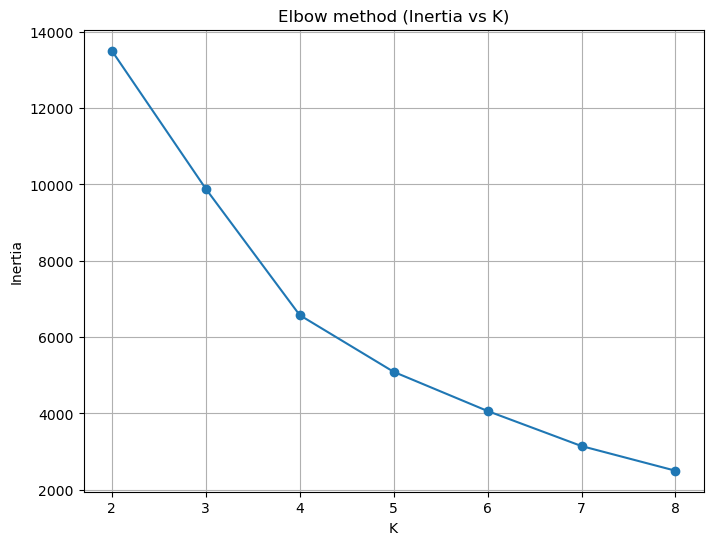

In [5]:
# %%
features = ["Recency","Frequency","MonetaryNet","ReturnRatio"]
X = rfm[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertias = []
ks = range(2, 9)
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow method (Inertia vs K)")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

In [6]:

K = 4
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(X_scaled)

sil = silhouette_score(X_scaled, rfm["Cluster"])
print(f"Silhouette score (K={K}): {sil:.3f}")

rfm["Cluster"].value_counts().sort_index()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(


Silhouette score (K=4): 0.589


Cluster
0    3240
1      26
2    1104
3       1
Name: count, dtype: int64

<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">2D Visualization via PCA</h4>
</div>


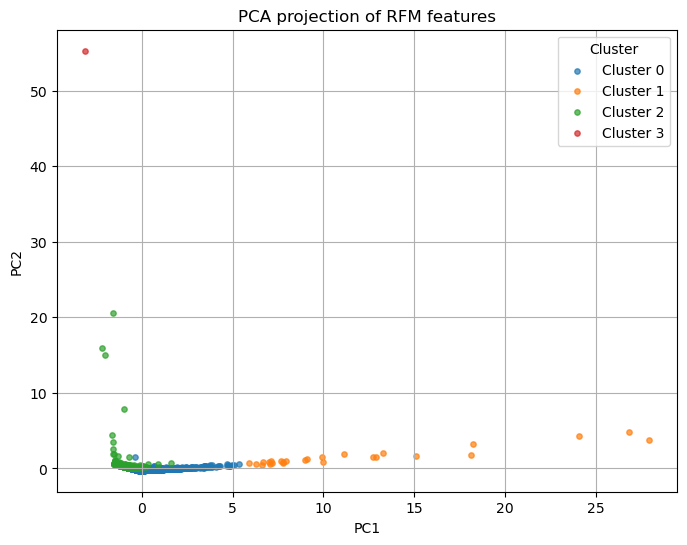

In [7]:
# ## 2D visualization with PCA

# %%
pca = PCA(n_components=2, random_state=42)
pts = pca.fit_transform(X_scaled)
pcadf = pd.DataFrame(pts, columns=["PC1","PC2"])
pcadf["Cluster"] = rfm["Cluster"].values

plt.figure()
for c in sorted(pcadf["Cluster"].unique()):
    m = pcadf["Cluster"] == c
    plt.scatter(pcadf.loc[m,"PC1"], pcadf.loc[m,"PC2"], s=15, label=f"Cluster {c}", alpha=0.7)
plt.legend(title="Cluster")
plt.title("PCA projection of RFM features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Cluster profiling (means, medians, and percentiles)</h4>
</div>


In [8]:
def profile(df_seg, features, cluster_col="Cluster"):
    aggs = {}
    for f in features:
        aggs[f] = ["mean","median","std","min",lambda x: np.percentile(x,25), "max", lambda x: np.percentile(x,75)]
    prof = df_seg.groupby(cluster_col).agg(aggs)
    # prettify colnames
    prof.columns = ['_'.join([c for c in col if isinstance(c, str)]) if isinstance(col, tuple) else col
                    for col in prof.columns]
    prof = prof.rename(columns={
        "Recency_<lambda_0>":"Recency_p25","Recency_<lambda_1>":"Recency_p75",
        "Frequency_<lambda_0>":"Frequency_p25","Frequency_<lambda_1>":"Frequency_p75",
        "MonetaryNet_<lambda_0>":"MonetaryNet_p25","MonetaryNet_<lambda_1>":"MonetaryNet_p75",
        "ReturnRatio_<lambda_0>":"ReturnRatio_p25","ReturnRatio_<lambda_1>":"ReturnRatio_p75",
    })
    return prof

profile_table = profile(rfm, features)
profile_table

,Recency_mean,Recency_median,Recency_std,Recency_min,Recency_p25,Recency_max,Recency_p75,Frequency_mean,Frequency_median,Frequency_std,...,MonetaryNet_p25,MonetaryNet_max,MonetaryNet_p75,ReturnRatio_mean,ReturnRatio_median,ReturnRatio_std,ReturnRatio_min,ReturnRatio_p25,ReturnRatio_max,ReturnRatio_p75
Cluster,,,,,,,,,,,,,,,,,,,,,
0,39.132099,28.0,35.096029,0,10.00,162,60.0,5.549691,4.0,6.286413,...,396.8100,50415.49,2024.575,4.790126e+04,-0.000000e+00,2.388405e+06,-0.000000e+00,-0.000000e+00,1.348000e+08,1.252376e-02
1,4.923077,2.0,8.574022,0,0.25,38,3.0,83.269231,64.5,55.863088,...,34442.1225,279489.02,82567.055,5.644823e-02,2.879353e-02,7.486193e-02,2.558832e-03,1.730652e-02,3.706546e-01,7.860973e-02
2,245.457428,240.0,68.224644,136,185.00,373,300.0,1.846920,1.0,1.747198,...,155.8750,21535.90,509.430,5.406169e+06,-0.000000e+00,7.240413e+07,-0.000000e+00,-0.000000e+00,1.592490e+09,0.000000e+00
3,144.000000,144.0,NaN,144,144.00,144,144.0,1.000000,1.0,NaN,...,0.0000,0.00,0.000,4.287630e+09,4.287630e+09,NaN,4.287630e+09,4.287630e+09,4.287630e+09,4.287630e+09


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Human-Readable Segment Labels</h4>
</div>


In [9]:
# %%
# Heuristic: lower Recency = more recent; higher Frequency & MonetaryNet = more value
centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)
centers_unscaled = pd.DataFrame(scaler.inverse_transform(centers), columns=features)
centers_unscaled["Cluster"] = range(len(centers_unscaled))

# rank by MonetaryNet then Frequency, and penalize high ReturnRatio
centers_unscaled["value_score"] = (
    centers_unscaled["MonetaryNet"].rank(method="dense")*2
    + centers_unscaled["Frequency"].rank(method="dense")
    - centers_unscaled["ReturnRatio"].rank(method="dense")
    - centers_unscaled["Recency"].rank(method="dense")  # lower recency is better; rank subtracts it
)

centers_unscaled = centers_unscaled.sort_values("Cluster").reset_index(drop=True)

# Labeling rulebook (can be adjusted)
labels = {}
rank_order = centers_unscaled["value_score"].rank(method="dense", ascending=False)
for idx, r in enumerate(rank_order):
    if r == 1: labels[idx] = "Loyal Big Spenders"
    elif r == 2: labels[idx] = "Active Value Buyers"
    elif r == 3: labels[idx] = "Occasional / Newcomers"
    else: labels[idx] = "At-Risk / Low-Value"

rfm["Segment"] = rfm["Cluster"].map(labels)
rfm.head(10)

,CustomerID,Frequency,Monetary,Recency,MonetaryNet,ReturnRatio,Cluster,Segment
0,12346.0,2,0.00,325,0.00,1.000000,2,Occasional / Newcomers
1,12347.0,7,4310.00,1,4310.00,-0.000000,0,Active Value Buyers
2,12348.0,4,1797.24,74,1797.24,-0.000000,0,Active Value Buyers
3,12349.0,1,1757.55,18,1757.55,-0.000000,0,Active Value Buyers
4,12350.0,1,334.40,309,334.40,-0.000000,2,Occasional / Newcomers
5,12352.0,11,1545.41,35,1545.41,0.383326,0,Active Value Buyers
6,12353.0,1,89.00,203,89.00,-0.000000,2,Occasional / Newcomers
7,12354.0,1,1079.40,231,1079.40,-0.000000,2,Occasional / Newcomers
8,12355.0,1,459.40,213,459.40,-0.000000,2,Occasional / Newcomers
9,12356.0,3,2811.43,22,2811.43,-0.000000,0,Active Value Buyers


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Segment KPIs</h4>
</div>


In [10]:

kpi = (
    rfm.groupby(["Cluster","Segment"])
       .agg(Customers=("CustomerID","count"),
            MonetaryNet_Sum=("MonetaryNet","sum"),
            MonetaryNet_Mean=("MonetaryNet","mean"),
            Frequency_Mean=("Frequency","mean"),
            Recency_Median=("Recency","median"),
            ReturnRatio_Mean=("ReturnRatio","mean"))
       .reset_index()
)
kpi["RevenueShare_%"] = 100 * kpi["MonetaryNet_Sum"] / kpi["MonetaryNet_Sum"].sum()
kpi.sort_values("MonetaryNet_Sum", ascending=False)


,Cluster,Segment,Customers,MonetaryNet_Sum,MonetaryNet_Mean,Frequency_Mean,Recency_Median,ReturnRatio_Mean,RevenueShare_%
0,0,Active Value Buyers,3240,5818475.473,1795.825763,5.549691,28.0,4.790126e+04,69.990004
1,1,Loyal Big Spenders,26,1975126.070,75966.387308,83.269231,2.0,5.644823e-02,23.758643
2,2,Occasional / Newcomers,1104,519693.411,470.736785,1.846920,240.0,5.406169e+06,6.251353
3,3,At-Risk / Low-Value,1,0.000,0.000000,1.000000,144.0,4.287630e+09,0.000000


## Implementation with Novelty: Gaussian Mixture Models (GMM)


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Run GMM on your scaled RFM features</h4>
</div>


In [11]:
# Fit Gaussian Mixture with same number of clusters (K=4 for comparability)
gmm = GaussianMixture(n_components=4, random_state=42)
rfm["Cluster_GMM"] = gmm.fit_predict(X_scaled)

# Silhouette score for GMM
sil_gmm = silhouette_score(X_scaled, rfm["Cluster_GMM"])
print(f"Silhouette score (GMM, K=4): {sil_gmm:.3f}")

# Cluster sizes
print(rfm["Cluster_GMM"].value_counts())


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(


Silhouette score (GMM, K=4): 0.419
Cluster_GMM
2    3700
3     638
0      32
1       1
Name: count, dtype: int64


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Visualization of GMM clusters (PCA)</h4>
</div>


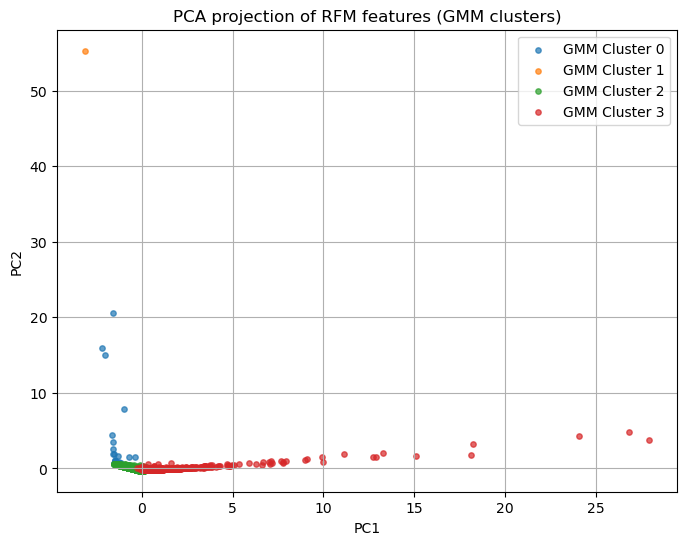

In [12]:
pca_gmm = PCA(n_components=2, random_state=42)
pts_gmm = pca_gmm.fit_transform(X_scaled)
pcadf_gmm = pd.DataFrame(pts_gmm, columns=["PC1","PC2"])
pcadf_gmm["Cluster_GMM"] = rfm["Cluster_GMM"].values

plt.figure()
for c in sorted(pcadf_gmm["Cluster_GMM"].unique()):
    m = pcadf_gmm["Cluster_GMM"] == c
    plt.scatter(pcadf_gmm.loc[m,"PC1"], pcadf_gmm.loc[m,"PC2"], s=15, label=f"GMM Cluster {c}", alpha=0.7)
plt.legend()
plt.title("PCA projection of RFM features (GMM clusters)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Segment KPI comparison</h4>
</div>


In [13]:
kpi_gmm = (
    rfm.groupby("Cluster_GMM")
       .agg(Customers=("CustomerID","count"),
            MonetaryNet_Sum=("MonetaryNet","sum"),
            MonetaryNet_Mean=("MonetaryNet","mean"),
            Frequency_Mean=("Frequency","mean"),
            Recency_Median=("Recency","median"),
            ReturnRatio_Mean=("ReturnRatio","mean"))
       .reset_index()
)
kpi_gmm["RevenueShare_%"] = 100 * kpi_gmm["MonetaryNet_Sum"] / kpi_gmm["MonetaryNet_Sum"].sum()
kpi_gmm.sort_values("MonetaryNet_Sum", ascending=False)



,Cluster_GMM,Customers,MonetaryNet_Sum,MonetaryNet_Mean,Frequency_Mean,Recency_Median,ReturnRatio_Mean,RevenueShare_%
3,3,638,5490013.520,8605.036865,17.515674,10.0,3.181591e-02,66.03896
2,2,3700,2823281.434,763.049036,2.966216,60.0,4.102638e-02,33.96104
0,0,32,0.000,0.000000,1.093750,353.5,1.913628e+08,0.00000
1,1,1,0.000,0.000000,1.000000,144.0,4.287630e+09,0.00000


## Implementation with Novelty: DBSCAN (Density-Based Clustering)


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">fit DBSCAN, check number of clusters, compute silhouette</h4>
</div>


In [14]:
# Fit DBSCAN (tune eps & min_samples as needed)
dbscan = DBSCAN(eps=1.5, min_samples=5)  
rfm["Cluster_DBSCAN"] = dbscan.fit_predict(X_scaled)

# Number of clusters (excluding noise = -1)
n_clusters_dbscan = len(set(rfm["Cluster_DBSCAN"])) - (1 if -1 in rfm["Cluster_DBSCAN"] else 0)
print(f"DBSCAN found {n_clusters_dbscan} clusters (excluding noise)")

# Silhouette only valid if >1 cluster
if n_clusters_dbscan > 1:
    sil_db = silhouette_score(X_scaled, rfm["Cluster_DBSCAN"])
    print(f"Silhouette score (DBSCAN): {sil_db:.3f}")
else:
    print("Silhouette score not applicable (only one cluster detected)")

print("Cluster distribution (DBSCAN):")
print(rfm["Cluster_DBSCAN"].value_counts())


DBSCAN found 2 clusters (excluding noise)
Silhouette score (DBSCAN): 0.896
Cluster distribution (DBSCAN):
Cluster_DBSCAN
 0    4337
-1      34
Name: count, dtype: int64


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">PCA scatterplot to visualize DBSCAN clusters</h4>
</div>


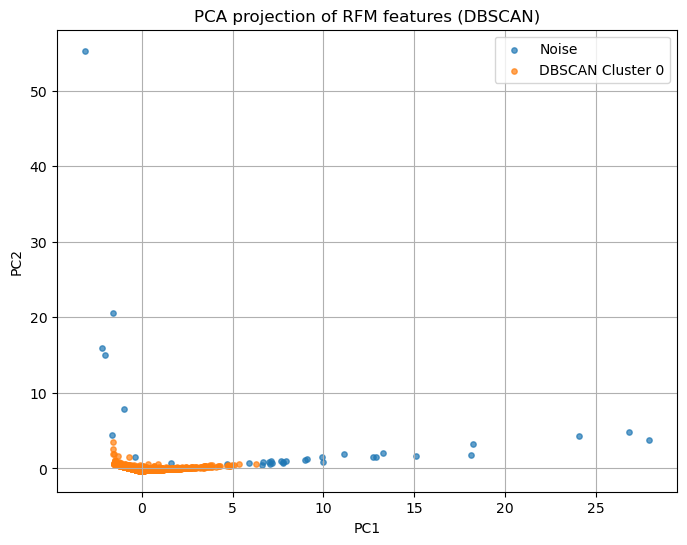

In [15]:
pca_db = PCA(n_components=2, random_state=42)
pts_db = pca_db.fit_transform(X_scaled)
pcadf_db = pd.DataFrame(pts_db, columns=["PC1","PC2"])
pcadf_db["Cluster_DBSCAN"] = rfm["Cluster_DBSCAN"].values

plt.figure()
for c in sorted(pcadf_db["Cluster_DBSCAN"].unique()):
    m = pcadf_db["Cluster_DBSCAN"] == c
    label = "Noise" if c == -1 else f"DBSCAN Cluster {c}"
    plt.scatter(pcadf_db.loc[m,"PC1"], pcadf_db.loc[m,"PC2"], s=15, label=label, alpha=0.7)
plt.legend()
plt.title("PCA projection of RFM features (DBSCAN)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">KPI summary for DBSCAN clusters</h4>
</div>


In [16]:
kpi_db = (
    rfm.groupby("Cluster_DBSCAN")
       .agg(Customers=("CustomerID","count"),
            MonetaryNet_Sum=("MonetaryNet","sum"),
            MonetaryNet_Mean=("MonetaryNet","mean"),
            Frequency_Mean=("Frequency","mean"),
            Recency_Median=("Recency","median"),
            ReturnRatio_Mean=("ReturnRatio","mean"))
       .reset_index()
)
kpi_db["RevenueShare_%"] = 100 * kpi_db["MonetaryNet_Sum"] / kpi_db["MonetaryNet_Sum"].sum()
kpi_db.sort_values("MonetaryNet_Sum", ascending=False)


,Cluster_DBSCAN,Customers,MonetaryNet_Sum,MonetaryNet_Mean,Frequency_Mean,Recency_Median,ReturnRatio_Mean,RevenueShare_%
1,0,4337,6315831.014,1456.267239,4.615864,49.0,2.700415e+05,75.972656
0,-1,34,1997463.940,58748.939412,63.735294,3.0,2.717668e+08,24.027344


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Method Agreement & Overlap (K-means vs GMM vs DBSCAN)</h4>
    <p>We quantify alignment across algorithms using Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI). We also show a cross-tab to surface systematic disagreements and the role of DBSCAN’s noise (−1)</p>
</div>


In [17]:
# --- Method agreement metrics (KMeans vs GMM vs DBSCAN) ---
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import pandas as pd

# Expect these columns to exist already from earlier sections:
# rfm["Cluster"]            -> KMeans
# rfm["Cluster_GMM"]        -> GMM (e.g., from np.argmax of responsibilities)
# rfm["Cluster_DBSCAN"]     -> DBSCAN (-1 = noise)

labels_km  = rfm["Cluster"].astype(int).to_numpy()
labels_gmm = rfm["Cluster_GMM"].astype(int).to_numpy()
labels_db  = rfm["Cluster_DBSCAN"].astype(int).to_numpy()

# Compute ARI/NMI (excluding DBSCAN noise for pairwise where appropriate)
mask_core = labels_db != -1
def safe_scores(a, b, mask=None):
    if mask is not None:
        a, b = a[mask], b[mask]
    return (adjusted_rand_score(a, b), normalized_mutual_info_score(a, b))

ari_km_gmm, nmi_km_gmm   = safe_scores(labels_km, labels_gmm)
ari_km_db,  nmi_km_db    = safe_scores(labels_km, labels_db, mask_core)
ari_gmm_db, nmi_gmm_db   = safe_scores(labels_gmm, labels_db, mask_core)

agreement = pd.DataFrame({
    "Pair": ["KMeans vs GMM","KMeans vs DBSCAN (core)","GMM vs DBSCAN (core)"],
    "ARI":  [ari_km_gmm,     ari_km_db,                 ari_gmm_db],
    "NMI":  [nmi_km_gmm,     nmi_km_db,                 nmi_gmm_db],
})
agreement.round(3)


,Pair,ARI,NMI
0,KMeans vs GMM,-0.05,0.111
1,KMeans vs DBSCAN (core),0.00,0.000
2,GMM vs DBSCAN (core),0.00,0.000


In [19]:
# --- Cross-tabs to visualize overlap (noise handled separately) ---
xtab_km_gmm = pd.crosstab(rfm["Cluster"], rfm["Cluster_GMM"], rownames=["KM"], colnames=["GMM"])
xtab_km_db  = pd.crosstab(rfm.loc[mask_core, "Cluster"], rfm.loc[mask_core, "Cluster_DBSCAN"], 
                          rownames=["KM"], colnames=["DBSCAN_core"])
xtab_gmm_db = pd.crosstab(rfm.loc[mask_core, "Cluster_GMM"], rfm.loc[mask_core, "Cluster_DBSCAN"], 
                          rownames=["GMM"], colnames=["DBSCAN_core"])

xtab_km_gmm, xtab_km_db, xtab_gmm_db


(GMM   0  1     2    3
 KM                   
 0     3  0  2630  607
 1     0  0     0   26
 2    29  0  1070    5
 3     0  1     0    0,
 DBSCAN_core     0
 KM               
 0            3238
 1               1
 2            1098,
 DBSCAN_core     0
 GMM              
 0              26
 2            3700
 3             611)

<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Stability Check (Bootstrap Jaccard)</h4>
    <p>We test robustness by bootstrapping customers, reclustering, and computing Jaccard similarity between original and resample assignments. Higher median Jaccard ⇒ more stable segments.</p>
</div>


In [21]:
# --- Bootstrap stability via Jaccard for KMeans & GMM ---
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

rng = np.random.default_rng(42)

X = rfm[["Recency","Frequency","MonetaryNet"]].to_numpy()
Xsc = StandardScaler().fit_transform(X)

def label_match_jaccard(labels_ref, labels_new):
    # Build contingency and match clusters greedily by max overlap
    ref_classes = np.unique(labels_ref)
    new_classes = np.unique(labels_new)
    C = pd.crosstab(labels_ref, labels_new)
    used_cols = set()
    js = []
    for r in ref_classes:
        # pick best matching column not yet used
        col = C.loc[r].sort_values(ascending=False).index[0]
        inter = C.loc[r, col]
        a = (labels_ref == r).sum()
        b = (labels_new == col).sum()
        js.append(inter / (a + b - inter + 1e-9))
    return np.mean(js)

def bootstrap_jaccard(estimator, k=None, n=50, sample_frac=0.7):
    labels_ref = estimator.fit_predict(Xsc) if hasattr(estimator, "fit_predict") else estimator.fit(Xsc).predict(Xsc)
    scores = []
    n_samples = len(Xsc)
    for _ in range(n):
        idx = rng.choice(n_samples, int(sample_frac*n_samples), replace=True)
        est = estimator.__class__(**estimator.get_params())
        lbl_new = est.fit_predict(Xsc[idx]) if hasattr(est, "fit_predict") else est.fit(Xsc[idx]).predict(Xsc[idx])
        # map new labels back to full set via nearest-centroid for comparison
        if isinstance(est, KMeans):
            # assign full data to nearest bootstrap centroids
            d = cdist(Xsc, est.cluster_centers_)
            lbl_full = d.argmin(axis=1)
        elif isinstance(est, GaussianMixture):
            lbl_full = est.predict(Xsc)
        else:
            continue
        scores.append(label_match_jaccard(labels_ref, lbl_full))
    return np.median(scores), np.quantile(scores, [0.1, 0.9])

km_est  = KMeans(n_clusters=int(pd.Series(labels_km).nunique()), n_init=10, random_state=42)
gmm_est = GaussianMixture(n_components=int(pd.Series(labels_gmm).nunique()), random_state=42)

km_med,  (km_p10, km_p90)   = bootstrap_jaccard(km_est)
gmm_med, (gmm_p10, gmm_p90) = bootstrap_jaccard(gmm_est)

pd.DataFrame({
    "Method":["KMeans","GMM"],
    "Jaccard_median":[km_med, gmm_med],
    "Jaccard_P10":[km_p10, gmm_p10],
    "Jaccard_P90":[km_p90, gmm_p90],
}).round(3)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Win

,Method,Jaccard_median,Jaccard_P10,Jaccard_P90
0,KMeans,0.745,0.572,0.917
1,GMM,0.547,0.504,0.711


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">DBSCAN Sensitivity Sweep (ε × min_samples)</h4>
    <p>We grid-search ε and min_samples to understand cluster count, core fraction, and silhouette on core points. This derisks “parameter lottery.”</p>
</div>


In [22]:
# --- DBSCAN sensitivity map ---
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_list = np.linspace(0.5, 3.0, 9)       # tune range to your scale
minpts_list = [3, 5, 8, 12, 20]
rows = []
for eps in eps_list:
    for m in minpts_list:
        db = DBSCAN(eps=eps, min_samples=m).fit(Xsc)
        lab = db.labels_
        n_clu = len(set(lab)) - (1 if -1 in lab else 0)
        core_mask = lab != -1
        core_frac = core_mask.mean()
        sil = np.nan
        if n_clu >= 2 and core_mask.sum() > 50:
            sil = silhouette_score(Xsc[core_mask], lab[core_mask])
        rows.append({"eps":eps, "min_samples":m, "n_clusters":n_clu,
                     "core_frac":core_frac, "silhouette_core":sil})
dbscan_sweep = pd.DataFrame(rows)
dbscan_sweep_pivot = dbscan_sweep.pivot(index="min_samples", columns="eps", values="n_clusters")
dbscan_sweep.head(10), dbscan_sweep_pivot


(      eps  min_samples  n_clusters  core_frac  silhouette_core
 0  0.5000            3           5   0.991993         0.484621
 1  0.5000            5           3   0.989019         0.656137
 2  0.5000            8           1   0.984443              NaN
 3  0.5000           12           1   0.983299              NaN
 4  0.5000           20           1   0.981698              NaN
 5  0.8125            3           2   0.993823         0.826315
 6  0.8125            5           1   0.992679              NaN
 7  0.8125            8           1   0.990391              NaN
 8  0.8125           12           1   0.989476              NaN
 9  0.8125           20           1   0.987875              NaN,
 eps          0.5000  0.8125  1.1250  1.4375  1.7500  2.0625  2.3750  2.6875  \
 min_samples                                                                   
 3                 5       2       3       2       2       2       1       1   
 5                 3       1       1       1       2   

<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Revenue Lift Curve (Business Signal)</h4>
    <p>We show how quickly revenue accumulates as we include customers sorted by segment value. This reframes segmentation as ROI, not just geometry.</p>
</div>


(         count         sum  avg_value
 Cluster                              
 1           26  1975126.07   75966.39
 0         3240  5818475.47    1795.83
 2         1104   519693.41     470.74
 3            1        0.00       0.00,
                 count         sum  avg_value
 Cluster_DBSCAN                              
 0                4337  6315831.01    1456.27)

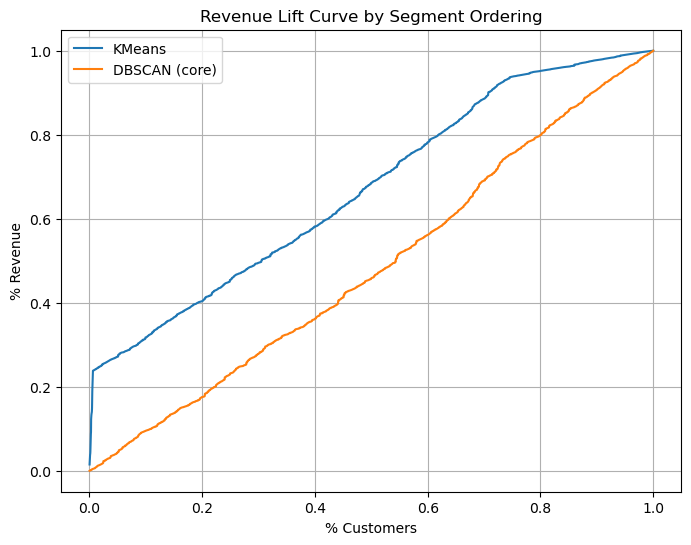

In [23]:
# --- Revenue lift curve for KMeans and DBSCAN (core) ---
def lift_curve(df, label_col, value_col="MonetaryNet"):
    kpi = (df.groupby(label_col)[value_col]
             .agg(["count","sum","mean"])
             .rename(columns={"mean":"avg_value"})
             .sort_values("avg_value", ascending=False))
    # order customers by their segment avg_value
    order = kpi.index.tolist()
    df2 = df.copy()
    df2["_seg_order"] = pd.Categorical(df2[label_col], categories=order, ordered=True)
    df2 = df2.sort_values("_seg_order")
    df2["cum_customers_%"] = np.arange(1, len(df2)+1)/len(df2)
    df2["cum_revenue_%"] = df2[value_col].cumsum()/df2[value_col].sum()
    return df2[["cum_customers_%","cum_revenue_%"]], kpi

lift_km, kpi_km = lift_curve(rfm, "Cluster", "MonetaryNet")
lift_db, kpi_db = lift_curve(rfm.loc[rfm["Cluster_DBSCAN"]!=-1], "Cluster_DBSCAN", "MonetaryNet")

import matplotlib.pyplot as plt
plt.figure(); plt.plot(lift_km["cum_customers_%"], lift_km["cum_revenue_%"], label="KMeans")
plt.plot(lift_db["cum_customers_%"], lift_db["cum_revenue_%"], label="DBSCAN (core)")
plt.title("Revenue Lift Curve by Segment Ordering"); plt.xlabel("% Customers"); plt.ylabel("% Revenue"); plt.legend()
kpi_km.round(2), kpi_db.round(2)


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Interpretable Rules for Stakeholders (Tree Surrogate for K-means)</h4>
    <p>We train a shallow decision tree to approximate K-means assignments, yielding human-readable if-then rules (recency/frequency/monetary thresholds)</p>
</div>


In [24]:
# --- Decision Tree surrogate for KMeans clusters (interpretability) ---
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import cross_val_score

Xr = rfm[["Recency","Frequency","MonetaryNet"]].to_numpy()
y  = rfm["Cluster"].astype(int).to_numpy()

tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=100, random_state=42)
cv_acc = cross_val_score(tree, Xr, y, cv=5, scoring="accuracy").mean()
tree.fit(Xr, y)
print(f"Tree surrogate CV accuracy: {cv_acc:.3f}")
print(export_text(tree, feature_names=["Recency","Frequency","MonetaryNet"]))


Tree surrogate CV accuracy: 0.989
|--- Recency <= 138.50
|   |--- Frequency <= 24.50
|   |   |--- Recency <= 121.50
|   |   |   |--- class: 0
|   |   |--- Recency >  121.50
|   |   |   |--- class: 0
|   |--- Frequency >  24.50
|   |   |--- class: 0
|--- Recency >  138.50
|   |--- Recency <= 155.50
|   |   |--- class: 2
|   |--- Recency >  155.50
|   |   |--- MonetaryNet <= 908.10
|   |   |   |--- class: 2
|   |   |--- MonetaryNet >  908.10
|   |   |   |--- class: 2



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


<div style="background-color: #f9f9f9; border-left: 5px solid #4caf50; padding: 10px; margin: 15px 0; border-radius: 5px; box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);">
    <h4 style="margin: 0; color: #4caf50; font-weight: bold; font-size: 18px;">Save charts and tables</h4>
</div>


In [26]:
# %%
# ============================
# Save charts and tables 
# ============================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

os.makedirs("exports", exist_ok=True)

# --- 1) Re-plot Elbow for export ---
inertias = []
for k in range(2, 9):
    km_tmp = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
    inertias.append(km_tmp.inertia_)
plt.figure()
plt.plot(range(2, 9), inertias, marker="o")
plt.title("Elbow")
plt.xlabel("K"); plt.ylabel("Inertia")
plt.savefig("exports/elbow.png", bbox_inches="tight"); plt.close()

# --- 2) PCA plots for each method (if labels present) ---
def save_pca_scatter(X_scaled, labels, title, fname, label_map=None):
    pca_local = PCA(n_components=2, random_state=42)
    pts = pca_local.fit_transform(X_scaled)
    dfp = pd.DataFrame(pts, columns=["PC1","PC2"])
    dfp["label"] = labels
    plt.figure()
    for c in sorted(pd.unique(dfp["label"])):
        mask = dfp["label"] == c
        lbl = label_map.get(c, c) if label_map else c
        plt.scatter(dfp.loc[mask,"PC1"], dfp.loc[mask,"PC2"], s=15, alpha=0.7, label=lbl)
    plt.legend(title="Cluster")
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.savefig(f"exports/{fname}", bbox_inches="tight"); plt.close()

# K-means
if "Cluster" in rfm.columns:
    save_pca_scatter(X_scaled, rfm["Cluster"].values, "PCA projection (K-means)", "pca_kmeans.png")

# GMM
if "Cluster_GMM" in rfm.columns:
    save_pca_scatter(X_scaled, rfm["Cluster_GMM"].values, "PCA projection (GMM)", "pca_gmm.png")

# DBSCAN (-1 = noise)
if "Cluster_DBSCAN" in rfm.columns:
    lbl_map = {-1: "Noise"}
    save_pca_scatter(X_scaled, rfm["Cluster_DBSCAN"].values, "PCA projection (DBSCAN)", "pca_dbscan.png", label_map=lbl_map)

# --- 3) Export master row-level table ---
rfm.to_csv("exports/rfm_with_segments.csv", index=False)

# --- 4) Export KPI tables (if available) ---
# K-means baseline KPI (original variable name `kpi`)
if 'kpi' in globals():
    kpi.to_csv("exports/segment_kpis_kmeans.csv", index=False)

# GMM KPI (variable `kpi_gmm`)
if 'kpi_gmm' in globals():
    kpi_gmm.to_csv("exports/segment_kpis_gmm.csv", index=False)

# DBSCAN KPI (variable `kpi_db`)
if 'kpi_db' in globals():
    kpi_db.to_csv("exports/segment_kpis_dbscan.csv", index=False)

# Cluster profile stats (from your profiling function)
if 'profile_table' in globals():
    profile_table.to_csv("exports/cluster_profile_stats.csv")

# Unscaled centers for K-means (if computed)
if 'centers_unscaled' in globals():
    centers_unscaled.to_csv("exports/cluster_centers_unscaled.csv", index=False)

# --- 5) Agreement & Crosstabs (if you ran the method-agreement block) ---
if 'agreement' in globals():
    agreement.to_csv("exports/method_agreement_ari_nmi.csv", index=False)

if 'xtab_km_gmm' in globals():
    xtab_km_gmm.to_csv("exports/xtab_kmeans_vs_gmm.csv")
if 'xtab_km_db' in globals():
    xtab_km_db.to_csv("exports/xtab_kmeans_vs_dbscan_core.csv")
if 'xtab_gmm_db' in globals():
    xtab_gmm_db.to_csv("exports/xtab_gmm_vs_dbscan_core.csv")

# --- 6) Stability (bootstrap Jaccard) if computed ---
if {'km_med','km_p10','km_p90','gmm_med','gmm_p10','gmm_p90'}.issubset(set(globals().keys())):
    pd.DataFrame({
        "Method":["KMeans","GMM"],
        "Jaccard_median":[km_med, gmm_med],
        "Jaccard_P10":[km_p10, gmm_p10],
        "Jaccard_P90":[km_p90, gmm_p90],
    }).to_csv("exports/cluster_stability_bootstrap_jaccard.csv", index=False)

# --- 7) DBSCAN sensitivity sweep grid (if run) ---
if 'dbscan_sweep' in globals():
    dbscan_sweep.to_csv("exports/dbscan_sensitivity_grid.csv", index=False)

# --- 8) Revenue lift curves + segment ordering KPIs (if run) ---
if 'lift_km' in globals() and 'lift_db' in globals():
    plt.figure()
    plt.plot(lift_km["cum_customers_%"], lift_km["cum_revenue_%"], label="KMeans")
    plt.plot(lift_db["cum_customers_%"], lift_db["cum_revenue_%"], label="DBSCAN (core)")
    plt.title("Revenue Lift Curve by Segment Ordering")
    plt.xlabel("% Customers"); plt.ylabel("% Revenue")
    plt.legend()
    plt.savefig("exports/lift_curve_km_vs_dbscan.png", bbox_inches="tight"); plt.close()
if 'kpi_km' in globals():
    kpi_km.to_csv("exports/segment_ordering_kpi_kmeans.csv")
if 'kpi_db' in globals():
    # note: kpi_db already exported above; keep both names if you like
    kpi_db.to_csv("exports/segment_ordering_kpi_dbscan.csv", index=False)

# --- 9) Decision-tree surrogate rules (if run) ---
# Save plain-text rules and CV accuracy for stakeholder readability
if 'tree' in globals():
    try:
        from sklearn.tree import export_text
        with open("exports/tree_surrogate_rules.txt", "w", encoding="utf-8") as f:
            f.write(f"Tree surrogate (max_depth={tree.get_params().get('max_depth')}, "
                    f"min_samples_leaf={tree.get_params().get('min_samples_leaf')})\n")
        # re-print rules (export_text requires the fitted tree)
        txt_rules = export_text(tree, feature_names=["Recency","Frequency","MonetaryNet"])
        with open("exports/tree_surrogate_rules.txt", "a", encoding="utf-8") as f:
            f.write("\nRules:\n")
            f.write(txt_rules)
        # CV accuracy if computed
        if 'cv_acc' in globals():
            with open("exports/tree_surrogate_rules.txt", "a", encoding="utf-8") as f:
                f.write(f"\n\nCV Accuracy: {cv_acc:.3f}\n")
    except Exception as e:
        print("Could not save tree rules:", e)

print("Saved assets to ./exports :",
      "\n - elbow.png",
      "\n - pca_clusters.png",
      "\n - rfm_with_segments.csv",
      "\n - segment_kpis_",
      "\n - cluster_profile_stats.csv, cluster_centers_unscaled.csv",
      )


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=18.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Win

Saved assets to ./exports : 
 - elbow.png 
 - pca_clusters.png 
 - rfm_with_segments.csv 
 - segment_kpis_ 
 - cluster_profile_stats.csv, cluster_centers_unscaled.csv
